## Executive Summary
We aim to use simple linear regression to estimate the sale price of residential properties in parts of Cook County, Illinois. We use a dataset from the Cook County Assessor Office (CCAO) that contain information such as a property's PIN (area,subarea,parcel,etc.), footage of land and building, number of rooms, and others. A multivariate model is more appropriate to a bivariate one as there are multiple features that are in play at the same time. Using statistical hypothesis testing as a preliminary step, we pick a few consolidated features to be incorporated in our model. Most importantly, since there are 31 areas represented in the dataset, each containing a resonably large number of properties, we developed a customed model for each of these different areas. This notebook presents the steps in the entire process, starting from visual inspection, basic data cleaning, hypothesis testing, feature engineering and regression model fitting.

## 1. Introduction
The Cook County Assessment Office, CCAO, needs to assess property value. This project focuses on single-family homes. Our main tool is that of linear regression (be it bivariate or multivariate). We will use a data set provided by CCAO with an accompanying explanation of the keys. Like all data sets, some amount of cleaning will be needed. As there are multiple features associated with each property, one needs in general to analyze which are relevant. Moreover, some relevant features may not be of a continuous or even numerical in nature, thus some transformations are likely needed.

In [ ]:
#This is a colab notebook. The following are specifics in loading the files on my local disk into the notebook
from google.colab import files
import io
uploaded = files.upload()



Saving Project-1-Data-Dictionary.csv to Project-1-Data-Dictionary (1).csv
Saving project1data.csv to project1data (1).csv


In [ ]:
#Basic imports
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
#Read the two files into data frames
df_dict = pd.read_csv(io.BytesIO(uploaded['Project-1-Data-Dictionary.csv']))
df = pd.read_csv(io.BytesIO(uploaded["project1data.csv"]))

## 2. Data Set Description
The data set is examined in the usual ways: looking at the dictionary of the fields, using info of dataframe to see roughly how many of some of the important fields do not have values. Here are some observations due to the finds in the cells below but summarized here:
 * The description of the PIN in the dictionary is slightly mistaken. The dictionary says the 14-digit PIN consists of a number of fields that actually only add up to 12 digits. By going to the CCAO site and manually feeding some specific PIN numbers, it becomes clear that both the Block and Parcel are 3-digit codes. 
 * The Property_Class fields are consistent with the supposed fact that our datafile contains residential properties.
 * The distribution of Property_Class show that (a) there are a significant number of condos and that none of them have the information of number of rooms, explaining why there are so many missing "number of rooms" info. Since intuitively number of rooms is a siginficant factor affecting property price, we may have to establish two different predictors, one for non-condo and one for condo, the latter would not use number of rooms as an independent variable.
 * There are a couple of Property_Class with only a handful (<= 10) instances. One can consider dropping them in or regression model creation.
 * Examining the Property_Class 299 (condo), it seems that meaningful data are all lacking. Of these 5729 properties, none has info on number of bedrooms, bathrooms, building square feet. And only less than half have info on land square feet. It will be too unreliable to build any model for this property class.
 * The log of Sale Price resmebles (visually) of that of Gaussian. So for the purpose of filtering outliers, logarithm seems appropriate. And statistical testing that requires underlying distribution to be normal would likely want to use the logarithm of sale price. Nevertheless, linear regression is more appropriate for simple sale prices as we do not believe a linear change in features such as land size results in an exponential change in sale preice. 


In [ ]:
#First take a look at the meaning of the fields
for j in range(df_dict.shape[0]):
    print("%s:\n%s\n--------"%(df_dict.iloc[j][0],df_dict.iloc[j][1]))

PIN:
Unique Permanent Identification Number for each property. All PINs are 14 digits: 2 digits for area + 2 digits for sub area + 2 digits for block + 2 digits for parcel + 4 digits for the multicode
--------
Property Address:
Property street address, not the address of the taxpayer.
--------
Tax Year:
Tax year of sale. Tax year referrs to the year in which taxes due. Taxes are billed a year in arrears. If a sale ocurred in calendar year 2018, it will be in tax year 2019.
--------
Property Class:
Property class. For a list of property classes, seeÂ https://www.cookcountyassessor.com/assets/forms/classcode.pdf
--------
Census Tract:
Census tract identifier - full map available through the Census Bureau,Â https://www.census.gov/geo/maps-data/maps/2010ref/st17_tract.html
--------
Type of Residence:
Type of residence - 1 = one story, 2 = two-story, 3 = three-story or higher, 4 = split level, 5 = 1.5 story, 6 = 1.6 story, 7 = 1.7 story , 8 = 1.8 story , 9 = 1.9 story (Note: residences with

In [ ]:
#Inspect the dataframe
print(df.columns)
print(df.head())
print(df.info())
ll = np.array((df['Property_Class'].unique()),dtype=int)
np.sort(ll)
num = []
print("..Inspect numbers of properties in each class")
for i in np.sort(ll):
    num.append(df[df['Property_Class']==i].shape[0])
    print("Class %d, num properties %d"%(i,num[-1]))


Index(['PIN', 'Property_Address', 'Tax_Year', 'Property_Class', 'Census_Tract',
       'Type_of_Residence', 'Rooms', 'Bedrooms', 'Basement', 'Fireplaces',
       'Central_Air', 'Full_Baths', 'Half_Baths', 'Building_Square_Feet',
       'Land_Square_Feet', 'Age', 'Longitude', 'Latitude', 'Walkscore',
       'Walkfac', 'Sale_Price'],
      dtype='object')
              PIN                Property_Address  ...        Walkfac  Sale_Price
0   8124170000000  613 S SCHOOL ST MOUNT PROSPECT  ...  Car-Dependent      298000
1  13113220261025           7101 N CICERO STE 100  ...  Car-Dependent      171000
2   6352050000000        602  MAPLE DR STREAMWOOD  ...  Car-Dependent      255000
3  27174070330000                   10626 DANI LN  ...  Car-Dependent      254900
4  14312140120000            1507 SUNSET RIDGE RD  ...  Car-Dependent      715000

[5 rows x 21 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         


=====The following are info of CONDO: Property_Class==299 
Note the extreme lack of features in this Property Class
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5729 entries, 1 to 19998
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PIN                   5729 non-null   int64  
 1   Property_Address      5729 non-null   object 
 2   Tax_Year              5729 non-null   int64  
 3   Property_Class        5729 non-null   int64  
 4   Census_Tract          5663 non-null   float64
 5   Type_of_Residence     0 non-null      object 
 6   Rooms                 0 non-null      float64
 7   Bedrooms              0 non-null      float64
 8   Basement              0 non-null      object 
 9   Fireplaces            0 non-null      float64
 10  Central_Air           0 non-null      object 
 11  Full_Baths            2211 non-null   float64
 12  Half_Baths            0 non-null      float64
 13  Build

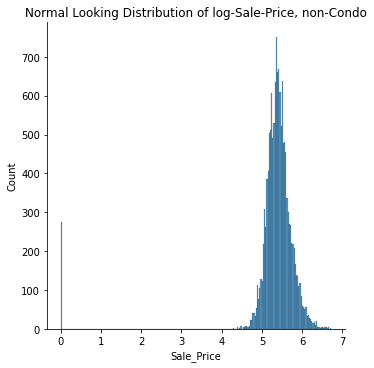

In [ ]:

df_condo = df[df['Property_Class']==299]
df_single = df[~(df['Property_Class']==299)]
print("\n=====The following are info of CONDO: Property_Class==299 ")
print("Note the extreme lack of features in this Property Class")
print(df_condo.info())
print("\n=====The following are info of non-CONDO: Property_Class NOT 299")
print(df_single.info())


sns.displot(np.log10(df_single['Sale_Price']))
plt.title("Normal Looking Distribution of log-Sale-Price, non-Condo")
plt.show()

## 3. Data Set Cleaning
Based on the previous observations, these are the cleaning steps. It is also important to note some of the implications of the steps.
 * Filter out records where number of rooms is null. IMPLICATION: all of the condo type are filtered out. That is, our model cannot predict condo type. More data is needed, perhaps by looking around for extra data. 
 * Filter outliers of the logarithmic of sale price
 * Filter out Property_Class with 10 or fewer data points
 * Location of a property is clearly important, so we create two additional keys of Area and Sub_Area based on the 14-digit PIN
 * Use Total_Rooms, assign the Grade as High, Medium, Low as in assignment 1

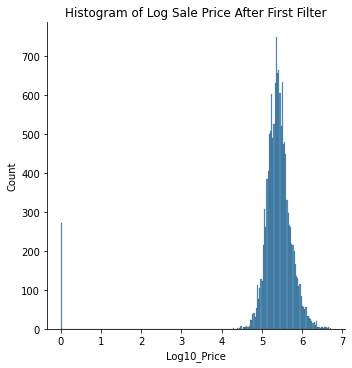

Q1, Q3 and IQR of Log Price are 5.217484, 5.574002, 0.356518


Text(0.5, 1.0, 'Histogram of Log Sale Price After Outlier Removal')

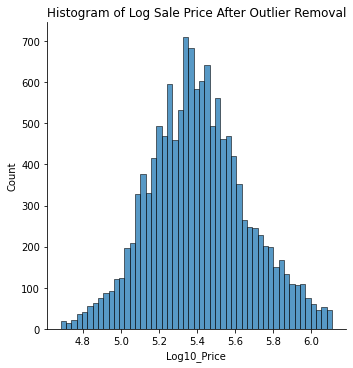

In [ ]:
df = df[~df['Rooms'].isna()]

df['Log10_Price'] = np.log10(df['Sale_Price'])

sns.displot(df['Log10_Price'],kde=None)
plt.title("Histogram of Log Sale Price After First Filter")
plt.show()
Q3 = df['Log10_Price'].quantile(0.75)
Q1 = df['Log10_Price'].quantile(0.25)
IQR = Q3-Q1
print("Q1, Q3 and IQR of Log Price are %f, %f, %f"%(Q1,Q3,IQR))

df = df[(df['Log10_Price']>Q1-1.5*IQR)]
df = df[(df['Log10_Price']<Q3+1.5*IQR)]
sns.displot(df['Log10_Price'],kde=None)
plt.title("Histogram of Log Sale Price After Outlier Removal")
#plt.show()

In [ ]:
out_lier_class = []
for i in df['Property_Class'].unique():
    if df[df['Property_Class']==i].shape[0] <= 10:
      out_lier_class.append(i)
print("Outlier Property Class :",out_lier_class)
for i in out_lier_class:
  df = df[~(df['Property_Class']==i)]


Outlier Property Class : [241, 297, 200, 201, 290, 288]


In [ ]:
df.columns

Index(['PIN', 'Property_Address', 'Tax_Year', 'Property_Class', 'Census_Tract',
       'Type_of_Residence', 'Rooms', 'Bedrooms', 'Basement', 'Fireplaces',
       'Central_Air', 'Full_Baths', 'Half_Baths', 'Building_Square_Feet',
       'Land_Square_Feet', 'Age', 'Longitude', 'Latitude', 'Walkscore',
       'Walkfac', 'Sale_Price', 'Log10_Price'],
      dtype='object')

In [ ]:
df = df[~df["Fireplaces"].isna()]
df = df[~df['Bedrooms'].isna()]
grades = []
for fireplace, bedroom in zip(df["Fireplaces"], df["Bedrooms"]): #Create a for loop iterating through each row's value for fireplace and bedroom
    if (fireplace>=2) or (bedroom>4):
        grades.append("High") #A property is a high grade if it has at least 2 fireplaces or more than 4 bedrooms
    elif (fireplace==1) or ((bedroom<=4) and (bedroom>=2)): #A property is medium if it has 1 fireplace or between 2 and 4 bedrooms
        grades.append("Medium")
    else:
        grades.append("Low")
df["Grade"] = grades #A new column with the grades for each property will be added as the final column
df = df.drop(["Fireplaces", "Bedrooms"], axis=1) #Drop the Fireplaces and Bedrooms columns

df["Half_Baths"] = df["Half_Baths"]*.5
df["Total_Rooms"]=df["Rooms"]+df["Full_Baths"]+df["Half_Baths"]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13568 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PIN                   13568 non-null  int64  
 1   Property_Address      13568 non-null  object 
 2   Tax_Year              13568 non-null  int64  
 3   Property_Class        13568 non-null  int64  
 4   Census_Tract          13566 non-null  float64
 5   Type_of_Residence     13568 non-null  object 
 6   Rooms                 13568 non-null  float64
 7   Basement              13568 non-null  object 
 8   Central_Air           13568 non-null  object 
 9   Full_Baths            13568 non-null  float64
 10  Half_Baths            13568 non-null  float64
 11  Building_Square_Feet  13568 non-null  float64
 12  Land_Square_Feet      13568 non-null  float64
 13  Age                   13568 non-null  float64
 14  Longitude             13568 non-null  float64
 15  Latitude           

## 4. Exploratory Data Analysis
Visualize to see if some of the more obvious factors that should affect sale prices. The several factors are Land_Square_Feet, Rooms, Walkscore
 * Create new fields of Area and Sub_Area as property value is related to location. Area is the first two digit of the 14-digit PIN and Sub_Area is the next two.
 * Visually, the land size seems to be quite uncorrelated with sale price. Neither does the total rooms. 
 * Box plot to visualize some basic characteristics of Area vs Price

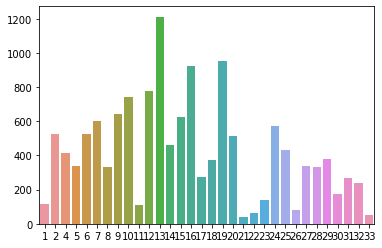

Area 13, Count 1212
Area 19, Count 955
Area 16, Count 924
Area 12, Count 775
Area 10, Count 743
Area  9, Count 642
Area 15, Count 626
Area  7, Count 604
Area 24, Count 575
Area  2, Count 526
Area  6, Count 525
Area 20, Count 515
Area 14, Count 461
Area 25, Count 431
Area  4, Count 416
Area 29, Count 378
Area 18, Count 371
Area  5, Count 339
Area 27, Count 338
Area 28, Count 335
Area  8, Count 330
Area 17, Count 275
Area 31, Count 266
Area 32, Count 236
Area 30, Count 174
Area 23, Count 137
Area  1, Count 114
Area 11, Count 112
Area 26, Count 81
Area 22, Count 61
Area 33, Count 52
Area 21, Count 39


In [ ]:
#Extract Area and Sub-Area from PIN
pin = np.array(df['PIN'], dtype=int)
loc_code = pin//10**10
Sub_Area = loc_code % 100
Area = loc_code // 100
df['Area'] = Area
df['Sub_Area'] = Sub_Area
areas = np.array(df['Area'].unique(),dtype=int)
areas = np.sort(areas)
property_cnt = []
for a in areas:
  property_cnt.append(df[df['Area']==a].shape[0])
property_cnt = np.array(property_cnt)
sns.barplot(x=areas,y=property_cnt)
plt.show()
ind = np.argsort(-property_cnt)
areas = areas[ind]
property_cnt = property_cnt[ind]
for a, cnt in zip(areas,property_cnt):
  print("Area %2d, Count %d"%(a,cnt))

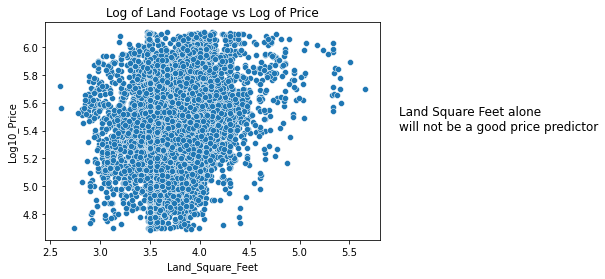

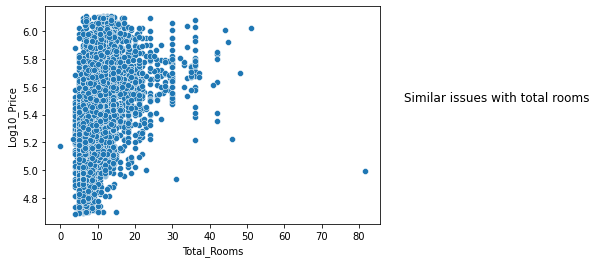

In [ ]:
#fig, axes = plt.subplots(1,3,figsize=(15,5),sharey=True)
#fig.suptitle('Scatter Plots of Sale Price w.r.t. Several Factors')
sns.scatterplot(x=np.log10(df['Land_Square_Feet']),y=df['Log10_Price'])
plt.title("Log of Land Footage vs Log of Price")
plt.text(6,5.4,"Land Square Feet alone\nwill not be a good price predictor",size='large')
plt.show()
sns.scatterplot(x=df['Total_Rooms'],y=df['Log10_Price'])
plt.text(92,5.5,'Similar issues with total rooms',size='large')

plt.show()




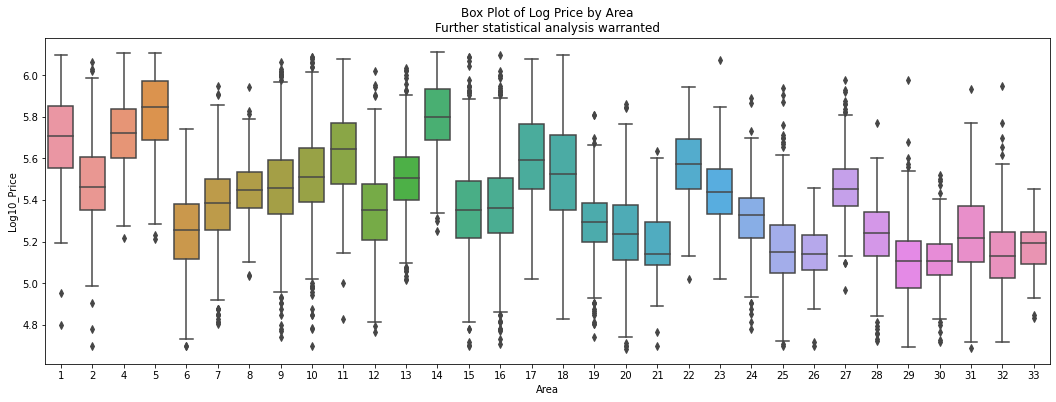

In [ ]:
plt.figure(figsize=(18,6))
sns.boxplot(x=df['Area'],y=df['Log10_Price'])
plt.title("Box Plot of Log Price by Area\nFurther statistical analysis warranted")
plt.show()


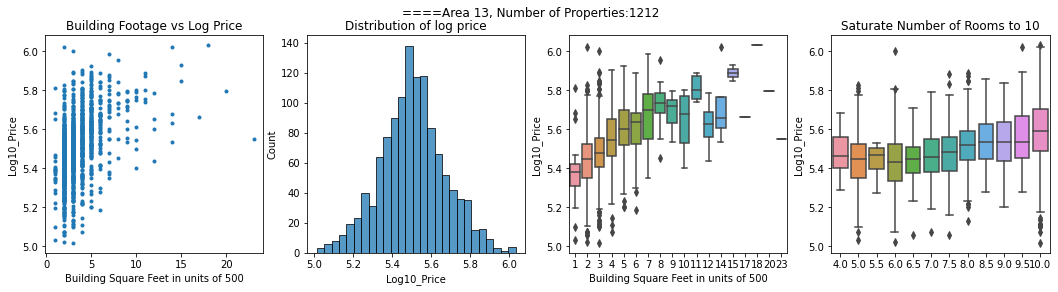

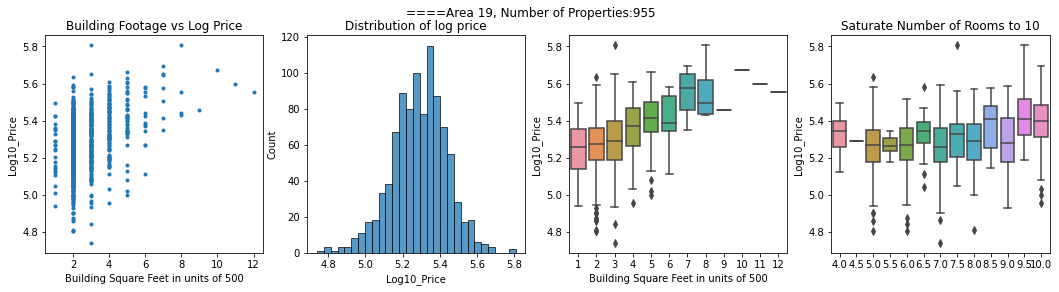

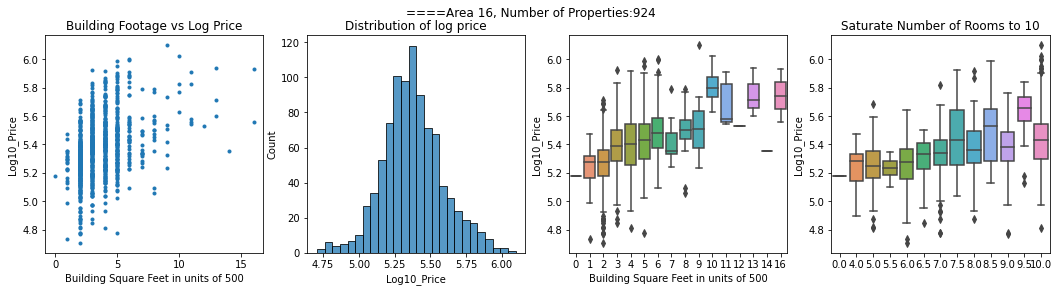

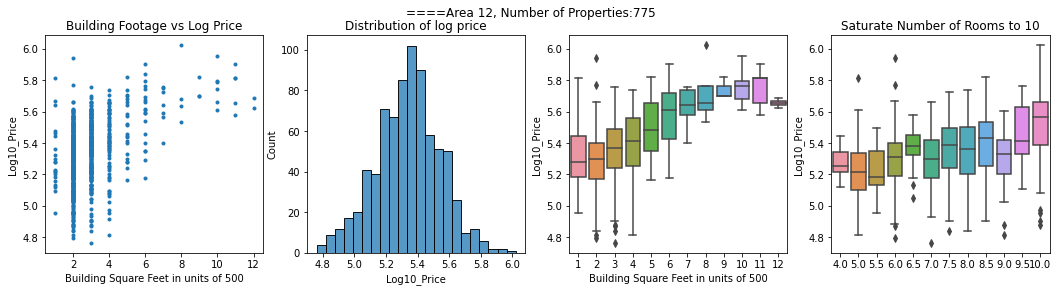

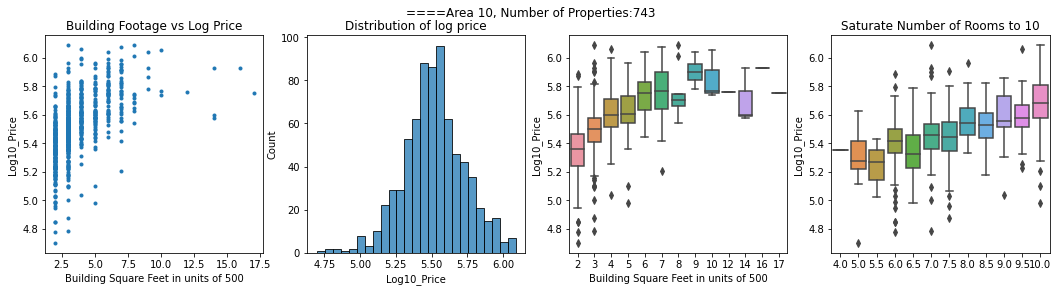

In [ ]:
# Take several of the areas with higher number of properties and see what factors may seems to correlate with price

for j in range(5):
  # areas are sorted with decreasing number of properties
  xx = df[df['Area']==areas[j]]

  fig,ax = plt.subplots(1,4,figsize=(18,4))
  plt.suptitle("====Area %d, Number of Properties:%d"%(areas[j],property_cnt[j]))

  sq_ft = np.round(np.array(xx['Building_Square_Feet'],dtype=int)/500)
  sq_ft = sq_ft.astype(int)
  
  ax[0].plot(sq_ft,xx['Log10_Price'],'.')
  ax[0].set_title("Building Footage vs Log Price"%(areas[j]))
  ax[0].set_xlabel("Building Square Feet in units of 500")
  ax[0].set_ylabel("Log10_Price")

  sns.histplot(xx['Log10_Price'],ax=ax[1])
  ax[1].set_title("Distribution of log price"%areas[j])

  sns.boxplot(x=sq_ft,y=xx['Log10_Price'],ax=ax[2])
  ax[2].set_xlabel("Building Square Feet in units of 500")
  rooms = np.minimum(np.array(xx['Total_Rooms']),10)
  sns.boxplot(x=rooms,y=xx['Log10_Price'],ax=ax[3])
  ax[3].set_title("Saturate Number of Rooms to 10")


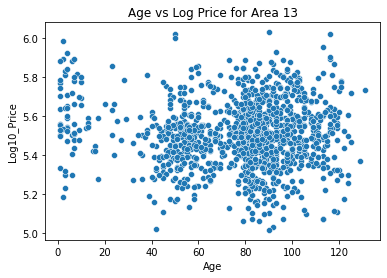

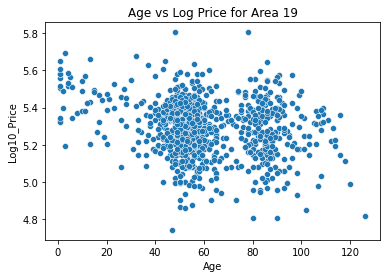

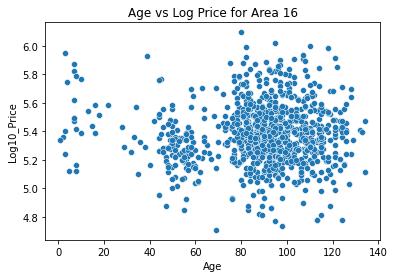

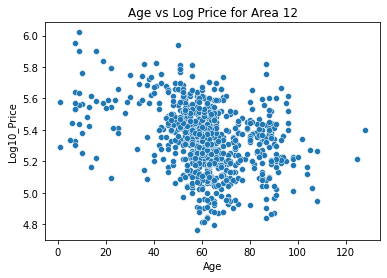

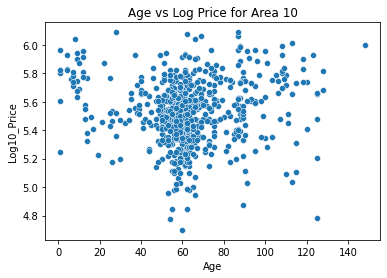

In [ ]:
for j in range(5):
  xx = df[df['Area']==areas[j]]
  sns.scatterplot(x=xx['Age'],y=xx['Log10_Price'])
  plt.title("Age vs Log Price for Area %d"%areas[j])  
  plt.show()

## 5. Hypothesis Testing
Examine if Areas, Grade, and Total Rooms are possibly significant
 * ANOVA on the top 5 areas in number of properties yields 0 p_value. Area is thus a good candidate to be included in a model
 * ANOVA on the three Grades yield 0 p_value. Grade is a good candidate for modeling
 * Pick the Total_Room numbers corresponding to the most properties

In [ ]:
# Prepare to use 1-way ANOVA to test if we can reject the Null Hypothesis that: Area is NOT a significant factor
# Test the top 5 areas having the largest number of properties
# It is tedious to type this long string, so one first creates this command as a string
arg_list = " "
for j in range(5):
  a = areas[j]
  sss= "var"+str(j)+"= df[df['Area']=="+str(a)+"]"
  print(sss)
  exec(sss)
  arg_list += "var"+str(j)+"['Log10_Price'],"
arg_list = arg_list[:-1]
sss = "f_score,p_value = stats.f_oneway("+arg_list+")"
print("to execute:%s:"%sss)
exec(sss)
print("Result yields: f_score = %f, p_value = %.3e"%(f_score,p_value))
print("---------------------------\n")


# Use 1-way ANOVA to test if we can reject the Null Hypothesis that: Grade is NOT a significant factor
arg_list = " "
for j,g in enumerate(df['Grade'].unique()):
  sss= "var"+str(j)+"= df[df['Grade']=='"+g+"']"
  print(sss)
  exec(sss)
  arg_list += "var"+str(j)+"['Log10_Price'],"
arg_list = arg_list[:-1]
sss = "f_score,p_value = stats.f_oneway("+arg_list+")"
print("to execute:%s:"%sss)
exec(sss)
print("Result yields: f_score = %f, p_value = %.3e"%(f_score,p_value))
print("---------------------------\n")



var0= df[df['Area']==13]
var1= df[df['Area']==19]
var2= df[df['Area']==16]
var3= df[df['Area']==12]
var4= df[df['Area']==10]
to execute:f_score,p_value = stats.f_oneway( var0['Log10_Price'],var1['Log10_Price'],var2['Log10_Price'],var3['Log10_Price'],var4['Log10_Price']):
Result yields: f_score = 269.378663, p_value = 2.524e-208
---------------------------

var0= df[df['Grade']=='Medium']
var1= df[df['Grade']=='High']
var2= df[df['Grade']=='Low']
to execute:f_score,p_value = stats.f_oneway( var0['Log10_Price'],var1['Log10_Price'],var2['Log10_Price']):
Result yields: f_score = 787.201071, p_value = 4.941e-324
---------------------------



In [ ]:
tr = []
tr_prop_cnt = []
for k in df['Total_Rooms'].unique():
  tr.append(k)
  tr_prop_cnt.append(df[df['Total_Rooms']==k].shape[0])
ind = np.argsort(-np.array(tr_prop_cnt))
tr = np.array(tr)
tr_prop_cnt = np.array(tr_prop_cnt)
tr=tr[ind]
tr_prop_cnt=tr_prop_cnt[ind]


In [ ]:
arg_list = " "
for j in range(10):
  a = tr[j]
  sss= "var"+str(j)+"= df[df['Total_Rooms']=="+str(a)+"]"
  print(sss)
  exec(sss)
  arg_list += "var"+str(j)+"['Log10_Price'],"
arg_list = arg_list[:-1]
sss = "f_score,p_value = stats.f_oneway("+arg_list+")"
print("to execute:%s:"%sss)
exec(sss)
print("Result yields: f_score = %f, p_value = %.3e"%(f_score,p_value))
print("---------------------------\n")


var0= df[df['Total_Rooms']==6.0]
var1= df[df['Total_Rooms']==7.5]
var2= df[df['Total_Rooms']==7.0]
var3= df[df['Total_Rooms']==8.5]
var4= df[df['Total_Rooms']==5.0]
var5= df[df['Total_Rooms']==8.0]
var6= df[df['Total_Rooms']==10.5]
var7= df[df['Total_Rooms']==9.5]
var8= df[df['Total_Rooms']==6.5]
var9= df[df['Total_Rooms']==9.0]
to execute:f_score,p_value = stats.f_oneway( var0['Log10_Price'],var1['Log10_Price'],var2['Log10_Price'],var3['Log10_Price'],var4['Log10_Price'],var5['Log10_Price'],var6['Log10_Price'],var7['Log10_Price'],var8['Log10_Price'],var9['Log10_Price']):
Result yields: f_score = 328.947076, p_value = 0.000e+00
---------------------------



## 6. Feature Engineering and Preprocessing
The continuous/numeric features include Building Square footage, Total Rooms. Based on previous observations, we staturate total rooms to 10.

There are a few categorical features.
 * For Grade, we will use 1-hot encoding, thus turning this to two variable, High and Medium. To avoid artificially creating column rank deficiency, we that the Low grade to be implied. (Although robust regression computation should not be able to handle rank deficiency.) In essence, we are adding one constant adjustment to each different Grade.
 * For Areas, we decide to simply use 1 model for area. 
 * Hence, we will create a new dataframe with trimmed down features: Area (dropping subarea), Total Rooms (saturates at 10), High_Grade (0 or 1), Medium_Grade (0 or 1), Building_Square_Footage, 


In [ ]:
new_dict = {}
new_dict['High_Grade']=1.*(df['Grade']=='High')
new_dict['Medium_Grade']=1.*(df['Grade']=='Medium')
new_dict['Sqft']=df['Building_Square_Feet']
new_dict['Area']=df['Area']
new_dict['Rooms']=np.minimum(np.array(df['Total_Rooms'],dtype=float),10.)
new_dict['LPrice']=df['Log10_Price']
new_dict['Price']=df['Sale_Price'].astype(float)
DF = pd.DataFrame(new_dict)
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13568 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High_Grade    13568 non-null  float64
 1   Medium_Grade  13568 non-null  float64
 2   Sqft          13568 non-null  float64
 3   Area          13568 non-null  int64  
 4   Rooms         13568 non-null  float64
 5   LPrice        13568 non-null  float64
 6   Price         13568 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5 MB


## 7. Model and Optimization
 * We employ multivariate linear regression using the statsmodels package. 
 * A simple trial with Grade/Sqft/Rooms features on each different Area shows rather big p-values for both the High_Grade and Medium_Grade coefficients. These features are subsequently dropped from the model altogehter, leaving only Sqrt and Rooms as features. This means that there are three parameters in the linear model.
 * There are 31 different Areas, and thus we obtain 31 linear models to predict the Log10 of Sale Price. Another run is made to predict the ordinary sale price (without logarithm).
 * The coefficients, their p-values, and the $R^2$ values are recorded into a dataframe and displayed.

In [ ]:
result_dict={}
from sklearn import linear_model
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


A, coeff_C, coeff_SF, coeff_RM = [],[],[],[]
p_C,p_SF,p_RM,Rsq = [],[],[],[]
for a in areas:
  xx = DF[DF['Area']==a]
  X = xx[['Sqft','Rooms']]
  X = sm.add_constant(X)
  Y = xx[['LPrice']]
  est = sm.OLS(Y,X)
  est_LP = est.fit()
  A.append(a)
  coeff_C.append(est_LP.params['const'])
  coeff_SF.append(est_LP.params['Sqft'])
  coeff_RM.append(est_LP.params['Rooms'])
  p_C.append(est_LP.pvalues['const'])
  p_SF.append(est_LP.pvalues['Sqft'])
  p_RM.append(est_LP.pvalues['Rooms'])
  Rsq.append(est_LP.rsquared)

result_LP = {'Area':A,'coeff_C':coeff_C,'coeff_SF':coeff_SF,'coeff_RM':coeff_RM,
             'p_C':p_C,'p_SF':p_SF,'p_RM':p_RM,'Rsq':Rsq}
DF_LP = pd.DataFrame(result_LP)
print("========FITTING Logarithmic Price with Two Features (3 Params), Multivariate Regression===========")
DF_LP.iloc[0:]

========FITTING Logarithmic Price with Two Features (3 Params), Multivariate Regression===========


,Area,coeff_C,coeff_SF,coeff_RM,p_C,p_SF,p_RM,Rsq
0,13,5.287329,0.000053,0.015955,0.000000e+00,2.598935e-23,1.204364e-07,0.208888
1,19,5.171473,0.000089,0.000182,0.000000e+00,8.559084e-15,9.632021e-01,0.127132
2,16,5.111518,0.000063,0.018779,0.000000e+00,1.187190e-11,1.422596e-04,0.158367
3,12,5.111887,0.000108,0.010218,0.000000e+00,7.801033e-19,8.281200e-02,0.216083
4,10,5.024175,0.000078,0.043651,0.000000e+00,4.553285e-15,1.749587e-13,0.358361
5,9,4.914448,0.000125,0.042121,0.000000e+00,7.088461e-25,7.112393e-11,0.483124
6,15,5.006381,0.000164,0.015548,0.000000e+00,1.397619e-24,1.775754e-02,0.360624
7,7,4.890090,0.000118,0.035964,0.000000e+00,2.835827e-28,3.997485e-12,0.451643
8,24,5.075223,0.000078,0.017878,0.000000e+00,1.157888e-13,3.625120e-04,0.265434
9,2,4.889046,0.000095,0.046224,0.000000e+00,3.407713e-31,8.819838e-19,0.584013


In [ ]:
A, coeff_C, coeff_SF, coeff_RM = [],[],[],[]
p_C,p_SF,p_RM,Rsq = [],[],[],[]
for a in areas:
  xx = DF[DF['Area']==a]
  X = xx[['Sqft','Rooms']]
  X = sm.add_constant(X)
  Y = xx[['Price']]
  est = sm.OLS(Y,X)
  est_P = est.fit()
  A.append(a)
  coeff_C.append(est_P.params['const'])
  coeff_SF.append(est_P.params['Sqft'])
  coeff_RM.append(est_P.params['Rooms'])
  p_C.append(est_P.pvalues['const'])
  p_SF.append(est_P.pvalues['Sqft'])
  p_RM.append(est_P.pvalues['Rooms'])
  Rsq.append(est_P.rsquared)

result_P = {'Area':A,'coeff_C':coeff_C,'coeff_SF':coeff_SF,'coeff_RM':coeff_RM,
             'p_C':p_C,'p_SF':p_SF,'p_RM':p_RM,'Rsq':Rsq}
DF_P = pd.DataFrame(result_P)
print("========FITTING Price with Two Features (3 Params), Multivariate Regression===========")
DF_P.iloc[0:]

========FITTING Price with Two Features (3 Params), Multivariate Regression===========


,Area,coeff_C,coeff_SF,coeff_RM,p_C,p_SF,p_RM,Rsq
0,13,167658.612910,50.887561,11143.704451,7.991722e-24,7.478580e-31,6.999519e-06,0.232644
1,19,142085.790998,51.767709,-607.078357,1.004634e-50,4.906819e-22,7.404572e-01,0.177832
2,16,104607.891627,53.715149,8462.707474,3.815372e-06,7.540416e-16,1.535367e-02,0.162618
3,12,111168.092439,86.646713,1324.922014,5.521929e-09,4.195129e-35,6.879617e-01,0.310828
4,10,-10926.407559,85.797837,28088.826019,7.401679e-01,3.949471e-22,6.775090e-08,0.359566
5,9,-41691.915292,143.499776,16208.962806,1.500132e-01,3.360301e-51,7.054984e-04,0.563863
6,15,21537.979036,141.001838,4664.982900,3.898258e-01,2.002752e-35,3.055312e-01,0.412934
7,7,-1056.670208,97.545313,12383.086787,9.531708e-01,3.293790e-56,8.909974e-06,0.549764
8,24,99033.203215,56.324416,5512.175695,3.681400e-11,3.188456e-25,2.972901e-02,0.342222
9,2,-44754.958414,100.725317,20241.918927,1.214627e-01,3.916754e-47,1.319221e-06,0.579013


## 8. Conclusion
While linear regression models are simple to implement and interpret, the preliminary results are quite inaccurate based on the somewhat low $R^2$ value. The datafile needs to be examined in more details. For example, a large class (condos) of properties do not have the information of number of rooms and in fact are currently not included in our model here. We find it unintutive that the simple feature of the quality of the property based on fireplaces and number of bedrooms do not seem to be statistically significant with respect to price. 

One worthwhile enhancement is to augment the current data set with more neighborhood information: schools rating, number of restaurants, crime rate. Since we have the latitude and longtitude information, it is quite plausible much of the information above is obtainable via some automation. One would of course need to locate these extra datasets.

We have not evaluted the prediction accuracy systematically. CCOA has some metric and we can also devise other metrics such as the expected relative difference of predicted price. 